In [1]:
!pip install torch==2.2
!pip install torchvision==0.17
!pip install nltk==3.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.1 MB/s eta 0:00:00
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

`torch.use_deterministic_algorithms(True)` Sets whether PyTorch operations must use deterministic algorithms. That is, algorithms which, given the same input, and when run on the same software and hardware, always produce the same output. When enabled, operations will use deterministic algorithms when available, and if only nondeterministic algorithms are available they will throw a RuntimeError when called.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

torch.use_deterministic_algorithms(True)

<p align="center">
  <img src="https://github.com/dancodermachine/mastering_pytorch_v2/blob/main/images/chap2_lenet.png?raw=True" />
</p>

In [3]:
class LeNet(nn.Module):

  def __init__(self):
    super().__init__()
    # 3 input image channel, 6 output feature maps and 5x5 conv Kernel
    self.cn1 = nn.Conv2d(3, 6, 5)
    # 6 input image channel, 16 output feature maps and 5x5 conv Kernel
    self.cn2 = nn.Conv2d(6, 16, 5)
    # Fully connected layers of size 120, 84, and 10
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # Convultion with 5x5 kernel
    x = F.relu(self.cn1(x))
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(x, (2, 2))
    # Convolution with 5x5 kernel
    x = F.relu(self.cn2(x))
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(x, (2, 2))
    # Flatten spatial and depth dimensions into a single vector
    x = x.view(-1, self.flattened_features(x))
    # Fully connected operations
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def flattened_features(self, x):
    # all except the first (batch) dimension
    size = x.size()[1:]
    num_feats = 1
    for s in size:
      num_feats *= s
    return num_feats

In [4]:
lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
def train(net, trainloader, optim, epoch):
  # initialize loss
  loss_total = 0.0

  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    # ip -> input images
    # ground_truth -> output classes the images belong to
    ip, ground_truth = data

    # zero the parameters gradients
    optim.zero_grad()

    # forward pass + backward pass + optimization step
    op = net(ip)
    loss = nn.CrossEntropyLoss()(op, ground_truth)
    loss.backward()
    optim.step()

    # update loss
    loss_total += loss.item()

    # print loss statistics
    if (i+1) % 1000 == 0: # print at the interval of 1000 mini-batches
      print("[Epoch number: %d, Mini-batches: %5d] loss: %.3f" % (epoch + 1,
                                                                  i+1,
                                                                  loss_total/200))
      loss_total = 0.0

In [6]:
def test(net, testloader):
  success = 0
  counter = 0
  with torch.no_grad():
    for data in testloader:
      im, ground_truth = data
      op = net(im)
      _, pred = torch.max(op.data, 1)
      counter += ground_truth.size(0)
      success += (pred == ground_truth).sum().item()

  print('LeNet accuracy on 10000 images from test dataset: %d %%' % (100 * success / counter))

In [7]:
# Train
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data",
                                        train=True,
                                        download=True,
                                        transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

# Test
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

# Ordering is important
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:02<00:00, 59750504.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


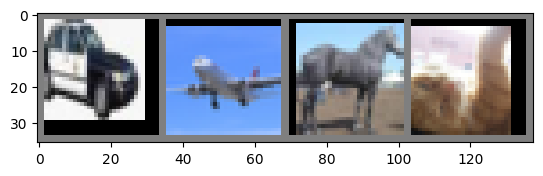

   car  ||  plane  ||  horse  ||  cat


In [8]:
def imageshow(image):
  # un-normalize the image
  image = image/2 + 0.5
  npimage = image.numpy()
  plt.imshow(np.transpose(npimage, (1, 2, 0)))
  plt.show()

# sample imaegs from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# display imageas in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
print("   " + "  ||  ".join(classes[labels[j]] for j in range(num_images)))

In [9]:
# define optimizer
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

# training loop over the dataset multiple times
for epoch in range(50):
  train(lenet, trainloader, optim, epoch)
  print()
  test(lenet, testloader)
  print()

print('Finished Training')

[Epoch number: 1, Mini-batches:  1000] loss: 9.938
[Epoch number: 1, Mini-batches:  2000] loss: 8.710
[Epoch number: 1, Mini-batches:  3000] loss: 8.292
[Epoch number: 1, Mini-batches:  4000] loss: 7.951
[Epoch number: 1, Mini-batches:  5000] loss: 7.602
[Epoch number: 1, Mini-batches:  6000] loss: 7.528

LeNet accuracy on 10000 images from test dataset: 50 %

[Epoch number: 2, Mini-batches:  1000] loss: 7.318
[Epoch number: 2, Mini-batches:  2000] loss: 7.206
[Epoch number: 2, Mini-batches:  3000] loss: 7.152
[Epoch number: 2, Mini-batches:  4000] loss: 7.017
[Epoch number: 2, Mini-batches:  5000] loss: 6.873
[Epoch number: 2, Mini-batches:  6000] loss: 7.031

LeNet accuracy on 10000 images from test dataset: 54 %

[Epoch number: 3, Mini-batches:  1000] loss: 6.707
[Epoch number: 3, Mini-batches:  2000] loss: 6.584
[Epoch number: 3, Mini-batches:  3000] loss: 6.617
[Epoch number: 3, Mini-batches:  4000] loss: 6.659
[Epoch number: 3, Mini-batches:  5000] loss: 6.662
[Epoch number: 3, M

In [10]:
model_path = 'cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

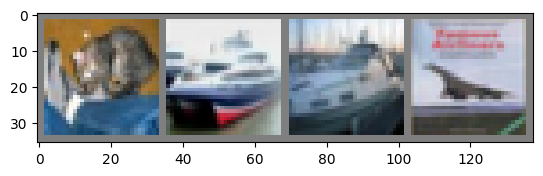

Label:          cat  ship  ship plane
Prediction:    cat  ship  ship plane


In [12]:
# Load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print("Label:       ", " ".join("%5s" % classes[ground_truth[j]] for j in range(4)))

# Load model
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# Model Inference
op = lenet_cached(im)

# Print Predictions
_, pred = torch.max(op, 1)

print("Prediction: ", " ".join("%5s" % classes[pred[j]] for j in range(4)))

In [13]:
success = 0
counter = 0
with torch.no_grad():
  for data in testloader:
    im, ground_truth = data
    op = lenet_cached(im)
    _, pred = torch.max(op.data, 1)
    counter += ground_truth.size(0)
    success += (pred == ground_truth).sum().item()

print("Model accuracy on 10000 images from test dataset: %d %%" % (100 * success / counter))

Model accuracy on 10000 images from test dataset: 68 %


In [15]:
class_success = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    im, ground_truth = data
    op = lenet_cached(im)
    _, pred = torch.max(op, 1)
    c = (pred == ground_truth).squeeze()
    for i in range(10000):
      ground_truth_curr = ground_truth[i]
      class_success[ground_truth_curr] += c[i].item()
      class_counter[ground_truth_curr] += 1

for i in range(10):
  print("Model accuracy for class %5s : %2d %%" % (classes[i], 100 * class_success[i] / class_counter[i]))

Model accuracy for class plane : 81 %
Model accuracy for class   car : 84 %
Model accuracy for class  bird : 55 %
Model accuracy for class   cat : 37 %
Model accuracy for class  deer : 61 %
Model accuracy for class   dog : 59 %
Model accuracy for class  frog : 83 %
Model accuracy for class horse : 72 %
Model accuracy for class  ship : 73 %
Model accuracy for class truck : 75 %


## Reference:
* https://github.com/arj7192/MasteringPyTorchV2/tree/main/Chapter02